# Задача 1b - MiptIceBucketChallenge.

Сперва напишем небольшой convinience-wrapper для симуляции ветвящегося процесса, после чего детальнее рассмотрим каждую из моделей, предложенных в задаче.

In [119]:
def sample_process(*, dist, start_population=1, iterations) -> list:
    """Trajectory of Galton-Watson process with given dirstribution.

    Args:
        dist: random variable defining branching result
        start_population: initial value of population (non-negative int)
        iterations: number of iterations to simulate
    Yields:
        process trajectory as sequence of integers
    """
    current_value = start_population
    for _ in range(iterations):
        yield current_value
        
        new_value = sum(dist(size=current_value))
        current_value = new_value

## 1. $\xi \sim R\{0, \ldots, N\}$

### Вероятность вырождения

Для нахождения веротяности вырождения вычислим производящую функцию случайной величины.
$$ E z^\xi = \frac{1}{N+1} \sum_{i=0}^{N} z^i = \frac{z^{N+1}-1}{(N+1)(z-1)} $$

Вероятность вырождения будет наименьшим корнем уравнения
$$ z(z - 1)(N + 1) = z^{N+1} - 1$$
на отрезке $[0, 1]$.

Формулы для общего случая, скорее всего, не существует (похоже, что уравнение неразрешимо в радикалах при $N \geqslant 5$), однако, в случае $N = 3$ интересующая нас вероятность легко находится ($\sqrt{2} - 1$), а при больших значениях $N$ её можно посчитать численно сколь угодно точно.

### Моделирование

Промоделируем процесс, чтобы убедиться в верности оценки. Будем считать, что процесс длится вечно, если он не вырождается за 20 итераций.

In [120]:
import functools
import numpy
import random

def extinction_probability(*, dist,
                           test_runs=300, iterations_threshold=20):
    """Numerically estimates process extinction probability.
    
    Args:
        dist: random variable defining branching process
        test_runs: number of rounds of simulation
        iterations_threshold: iterations for process simulation
    Returns:
        Fraction of extinctions occured during simulation.
    """
    extincted = 0
    for _ in range(test_runs):
        trajectory = list(sample_process(
                dist=dist, iterations=iterations_threshold))
        extincted += 1 if trajectory[-1] == 0 else 0
    return extincted / test_runs

def theoretical_probability(N):
    """Calculates exact theoretical value for extinction probability.
    
    Args:
        N: uniform distribution parameter (U[0; N])
    
    Returns:
        extinction probability: float from 0 to 1
    """
    poly = [1] * (N + 1)
    poly[-2] -= N + 1
    value = 1
    for root in numpy.roots(poly):
        if abs(root.imag) < 1e-5 and 0 < root.real < 1:
            value = min(value, root.real)
    return value

N = 3
discrete_uniform = functools.partial(numpy.random.randint, low=0, high=N+1)

print('numerical   = %f'
      % extinction_probability(dist=discrete_uniform))
print('theoritical = %f'
      % theoretical_probability(N))

numerical   = 0.413333
theoritical = 0.414214


Также построим несколько графиков траекторий процесса.

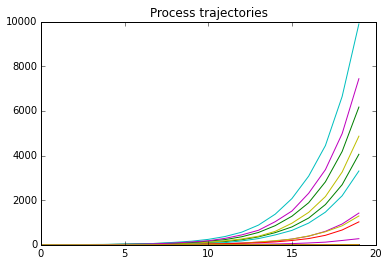

In [121]:
%matplotlib inline

from matplotlib import pyplot

def plot_trajectories(*, dist, trajectories, process_iterations):
    """Plots trajectories from given Galton-Watson process.
    
    Args:
        dist: random variable defining branching process
        trajectories: number of trajectories to plot
        process_iterations: number of iterations to simulate
    """
    for _ in range(trajectories):
        pyplot.plot(list(sample_process(dist=dist,
                                        iterations=process_iterations)))

plot_trajectories(dist=discrete_uniform, trajectories=20,
                  process_iterations=20)
pyplot.title('Process trajectories')
pyplot.show()

### Оценка момента вырождения

Параметра $p$ у в данной модели нет, мы можем разве что посмотреть, что будет при различных $N$. Впрочем, при $N \geqslant 3$ процесс имеет ненулевую вероятность длиться вечно, поэтому ожидание времени вырождения также бесконечно. При $N = 1$ время вырождения распределено как $\tau \sim Geom(\frac{1}{2})$ и имеет ожидание, равное $2$. 

Если $N = 3$, то так просто найти распределение не получается, но можно вычислить его программно. Из свойств производящих функций получаем, что
$$P(\tau = k) = P(X_k = 0) - P(X_{k-1} = 0) = \varphi_k(0) - \varphi_{k-1}(0).$$

Так как $\varphi_k = \underbrace{\varphi \circ \ldots \circ \varphi}_{k\,раз}$, где $\varphi = \frac{z^2 + z + 1}{3}$, то соответствующую вероятность можно посчитать за линейное время. Отбрасывая хвост бесконечного ряда, получаем приближение значения момента вырождения.

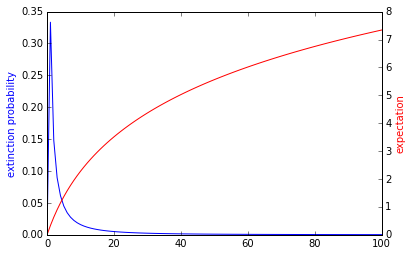

expectation calculated for 100 iterations = 7.341340


In [122]:
zero_prob = 0.0
expectation = 0.0
histogram, expectation = [0], [0]
iterations = 100

for step in range(iterations):
    new_prob = (zero_prob ** 2 + zero_prob + 1) / 3
    histogram.append(new_prob - zero_prob)
    cur_exp = expectation[-1] + (new_prob - zero_prob) * (step + 1)
    expectation.append(cur_exp)
    zero_prob = new_prob
    
_, l_axis = pyplot.subplots()
l_axis.plot(histogram)
l_axis.set_ylabel('extinction probability', color='b')

r_axis = l_axis.twinx()
r_axis.plot(expectation, color='r')
r_axis.set_ylabel('expectation', color='r')
pyplot.show()

print('expectation calculated for %d iterations = %f'
      % (iterations, expectation[-1]))

При увеличении числа итераций ожидание времени вымирания заметно растёт, вероятно $ET = +\infty$. Для доказательства полезно было бы найти асимптотику $1 - \varphi_k(0)$, однако не очень понятно, как это делать (имеет отношение к [quadratic map](http://mathworld.wolfram.com/QuadraticMap.html)?)

### Выбор числа $N$ и рост процесса

Ясно, что так как вероятность вырождения не меньше $\frac{1}{N+1}$ для любого $N$, то говорить об участии какого-то количества человек почти наверное не приходится.

Самым правильным было бы для каждого фиксированного $N \geqslant 2$ оценить $P(\exists k: X_k \geqslant 1000)$ и применить лемму Бореля-Кантелли, однако незамкнутый вид функции не позволяет сделать это напрямую.

Однако, судя по скорости убывания $\varphi_k$, вероятность вечно оставаться в отрезке $[0; 999]$ должна быть нулевой, и это можно проверить программно. Для каждого значения $N$ будем симулировать процесс до тех пор, пока он не выродится или не достигнет отметки в $1000$ человек.

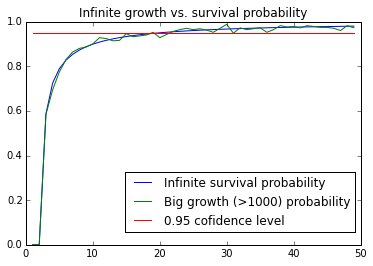

Value for confidence level 0.95 is ~19


In [123]:
def grow_probability(N, *, max_iterations=5000, test_runs=500):
    hits = 0
    discrete_uniform = functools.partial(numpy.random.randint, low=0, high=N+1)

    for _ in range(test_runs):
        for x in sample_process(dist=discrete_uniform, iterations=max_iterations):
            if x == 0:
                break
            if x >= 1000:
                hits += 1
                break
    return hits / test_runs

confidence, confidence_value = 0.95, -1
n_values, not_extinct, num_curve = list(range(1, 50)), list(), list()
for N in n_values:
    not_extinct.append(1 - theoretical_probability(N))
    num_curve.append(grow_probability(N))
    if confidence_value == -1 and num_curve[-1] > confidence:
        confidence_value = N
    
pyplot.plot(n_values, not_extinct, label='Infinite survival probability')
pyplot.plot(n_values, num_curve, label='Big growth (>1000) probability')
pyplot.plot(n_values, [confidence] * len(n_values), 
            label='%.2f cofidence level' % confidence, color='r')
pyplot.legend(bbox_to_anchor=(0.90, 0.40),
              bbox_transform=pyplot.gcf().transFigure)
pyplot.title('Infinite growth vs. survival probability')
pyplot.show()
print('Value for confidence level %.2f is ~%d' % (confidence, confidence_value))

Численный эксперимент показывает, что вероятность невырождения равна вероятности разрастания до достаточно большого (скорее всего произвольного, если честно моделировать достаточное число итераций) порога.

## 2. $\xi \sim Bin(N, p)$

### Вероятность вырождения

Производящая функция равна
$$\varphi(z) = Ez^\xi = \sum_{k=0}^{N}{{N}\choose{k}}z^k\cdot p^k (1-p)^{N-k} = (zp + 1 - p)^N.$$
Для $N = 3$ она принимает вид $\varphi(z) = (zp + 1 - p)^3$. Соответственно, для нахождения вероятности вырождения необходимо найти наименьший корень уравнения $\varphi(s) = s$. В общем случае вероятность вряд ли выражается, однако, например для $N = 3$ можно получить следующую формулу
$$s = 1 + \frac{3p^2-\sqrt{4p^3-3p^4}}{2p^3}, p>\frac{1}{3}.$$
В общем случае можно посчитать вероятность численно.

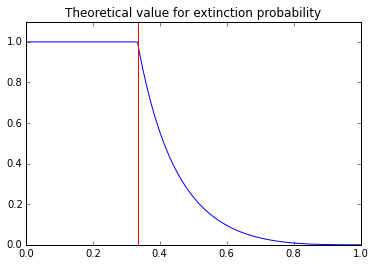

threshold probability ~ 0.334


In [124]:
from scipy.special import binom

def theoretical_probability(N, p):
    """Calculates exact theoretical value for extinction probability.
    
    Args:
        N, p: parameters for binomial distribution Bin(N, p)
    
    Returns:
        extinction probability: float from 0 to 1
    """
    poly = [(p ** k) * ((1 - p) ** (N - k)) * binom(N, k) for k in range(N, -1, -1)]
    poly[-2] -= 1.0
    value = 1
    for root in numpy.roots(poly):
        if abs(root.imag) < 1e-5 and 0 < root.real < 1:  # sort out imaginary roots
            value = min(value, root.real)
    return value

N = 3
probs = numpy.linspace(0.001, 0.999, 1000)
values = [theoretical_probability(N, p) for p in probs]

threshold = 0
for i in range(len(values)):
    if values[i] < 0.999:  # 1 - eps since there is numerical error in calculations
        threshold = probs[i]
        break
        
pyplot.plot(probs, values)
axes = pyplot.gca()
axes.set_ylim([0, 1.1])  # slightly more than 1.0

pyplot.axvline(x=threshold, color='r')
pyplot.title('Theoretical value for extinction probability')
pyplot.show()
print('threshold probability ~ %.3f' % threshold)

Естественно, что пороговая вероятность пришлась на $p = \frac{1}{3}$, так как в этом случае $E\xi = 1$.

### Моделирование

Убедимся в том, что наша оценка верна на практике, смоделировав процесс для разных значений $p$.

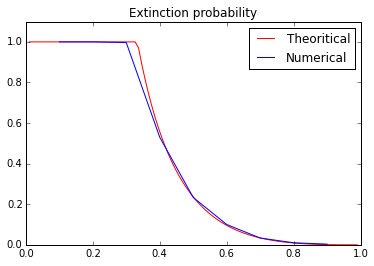

In [125]:
import functools

num_curve, num_probs = list(), numpy.linspace(0.1, 0.9, 9)
for p in num_probs:
    binomial_dist = functools.partial(numpy.random.binomial, N, p)
        
    # use only 10 iterations for large p to speed up calculations
    iterations = 30 if p < 0.4 else 10
    num_curve.append(extinction_probability(dist=binomial_dist,
                                            iterations_threshold=iterations))
    
theor_curve, theor_probs = list(), numpy.linspace(0.01, 0.99, 100)
for p in theor_probs:
    theor_curve.append(theoretical_probability(N, p))
    
axes = pyplot.gca()
axes.set_ylim([0, 1.1])  # slightly more than 1.0
pyplot.plot(theor_probs, theor_curve, color='r', label='Theoritical')
pyplot.plot(num_probs, num_curve, color='b', label='Numerical')
pyplot.title('Extinction probability')
pyplot.legend()
pyplot.show()

Также построим некоторое количество траекторий для разных $p$.

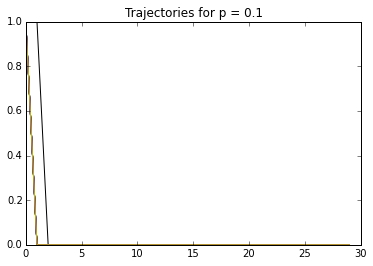

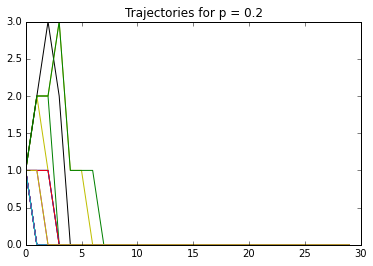

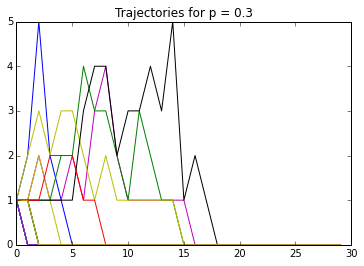

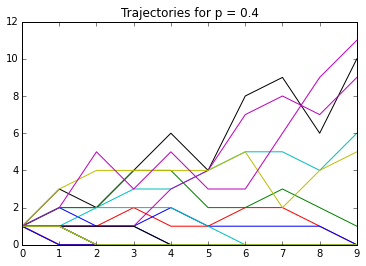

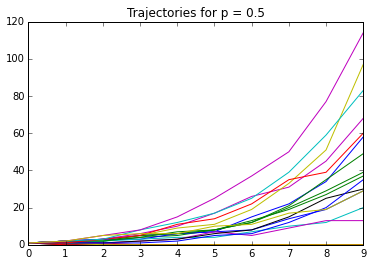

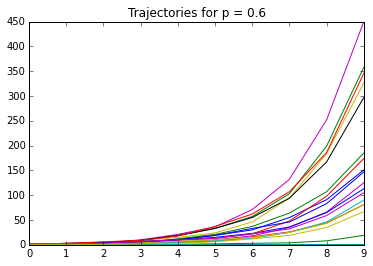

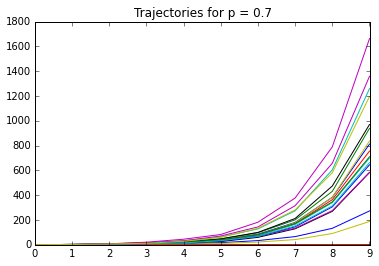

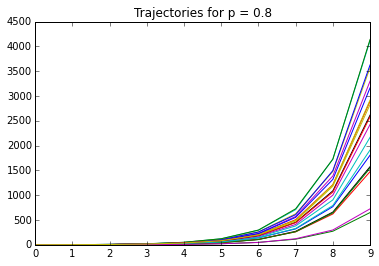

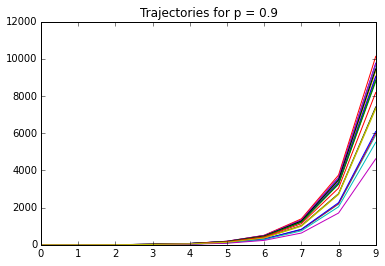

In [126]:
for p in numpy.linspace(0.1, 0.9, 9):
    binomial_dist = functools.partial(numpy.random.binomial, N, p)
    iterations = 30 if p < 0.33 else 10
    plot_trajectories(dist=binomial_dist, trajectories=20,
                      process_iterations=iterations)
    pyplot.title('Trajectories for p = %.1f' % p)
    pyplot.show()

Как и ожидалось, при $p < \frac{1}{3}$ процесс вырождается, иначе некоторые ветви неограниченно разрастаются.

### Оценка момента вырождения

Для момента вырождения имеем формулу
$$E \tau = \sum_{k=1}^{\infty}P(\tau=k)\cdot k = \sum_{k=1}^{\infty} (\varphi_k(0) - \varphi_{k-1}(0)) \cdot k.$$

Кубическая рекуррента не выглядит решаемой, поэтому удовлетворимся оценкой матожидания для разных $p < \frac{1}{3}$. Практически же мы можем получить сильно состоятельную оценку матожидания, пользуясь УЗБЧ: $\overline{X} \overset{п.н.}{\rightarrow} EX_i$.

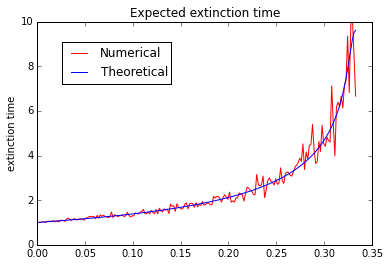

In [127]:
def extinction_time(p, *, iterations):
    """Calculates expected extinction time for process with xi ~ Bin(3, p).
    
    Args:
        p: parameter of distribution
        iterations: how terms in infinite sum to consider
    Returns:
        Estimate of expected extinction time.
    """
    zero_prob, expectation = 0.0, 0.0
    
    for step in range(iterations):
        new_prob = (zero_prob * p + 1 - p) ** 3
        expectation += (new_prob - zero_prob) * (step + 1)
        zero_prob = new_prob
    return expectation

def sample_extinction_time(dist, *, max_iterations=100):
    """Simulates process with given distribution and calculates extinction time.
    
    Args:
        dist: distribution of branching random variable
        max_iterations: maximum number of iterations to wait for extinction
    """
    extinction_time = 0
    for value in sample_process(dist=dist, iterations=max_iterations):
        if value == 0:
            return extinction_time
        extinction_time += 1
    return max_iterations

def numerical_extinction_time(p, *, test_runs=100):
    """Runs process several times to estimate exepected extinction time.
    
    Args:
        p: parameter of distribution
        test_runs: number of trajectories to sample
    """
    binomial_dist = functools.partial(numpy.random.binomial, N, p)
    values = [sample_extinction_time(binomial_dist) for _ in range(test_runs)]
    return sum(values) / len(values)

expectations = list()
probs = numpy.linspace(0.001, 0.333, 200)
expectations = [extinction_time(p, iterations=200) for p in probs]
num_expectations = [numerical_extinction_time(p) for p in probs]

_, l_axis = pyplot.subplots()
l_axis.plot(probs, num_expectations, color='r', label='Numerical')
l_axis.plot(probs, expectations, color='b', label='Theoretical')
l_axis.set_ylabel('extinction time')
l_axis.set_ylim([0, 10])
pyplot.title('Expected extinction time')
pyplot.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
pyplot.show()

Значения, близкие к $\frac{1}{3}$, сильнее зависят от числа итераций в подсчете ожидания, что, вероятно, указывает на то, что $E\tau \rightarrow +\infty$ при $p \rightarrow \frac{1}{3}$.

Доверительный интервал (асимптотический) можно построить отталкиваясь от ЦПТ. Мы знаем, что $\sqrt{n}\frac{\overline{X}-EX_i}{\sqrt{DX_i}} \overset{d}{\rightarrow} N(0, 1)$, то есть
$$ P\left(-\gamma < \sqrt{n} \frac{\overline{X} - EX_i}{\sqrt{DX_i}} \leqslant \gamma\right) \rightarrow \Phi(\gamma) - \Phi(-\gamma). $$
Для построения доверительного интервала уровня доверия $\alpha$ выберем $\gamma = z_{\frac{1+\alpha}{2}}$ - квантиль стандрартоного нормального распределения. В случае, если дисперсия $DX_i$ непрерывна по $p$, можно написать, что выборочная дисперсия стремится к дисперсии:
$$ S^2 = \frac{1}{n} \sum_{k=1}^{n} (X_i - \overline{X})^2 \overset{P}{\rightarrow} DX_i.$$

В таком случае доврительный интервал можно вычислить так:
$$ P\left(-\gamma < \sqrt{n} \frac{\overline{X} - EX_i}{\sqrt{S^2}} \leqslant \gamma\right) \rightarrow \alpha, $$
$$ P\left( \overline{X} -\frac{\gamma \sqrt{S^2}}{\sqrt{n}} < EX_i \leqslant \overline{X} + \frac{\gamma \sqrt{S^2}}{\sqrt{n}}\right) \rightarrow \alpha. $$

hit percentage = 0.91


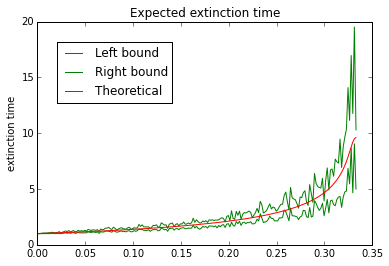

In [128]:
import scipy.stats

def confidence_interval(p, *, alpha=0.95, test_runs=100):
    """Gets samples of process extinction time to construct confidence interval.
    
    Args:
        p: parameter of distribution
        alpha: confidence level
        test_runs: number of samples
    """
    binomial_dist = functools.partial(numpy.random.binomial, N, p)
    values = [sample_extinction_time(binomial_dist) for _ in range(test_runs)]
    mean, deviation = numpy.mean(values), numpy.std(values)
    gamma = scipy.stats.norm.ppf((1 + alpha) / 2)
    return (mean - deviation * gamma / numpy.sqrt(test_runs),
            mean + deviation * gamma / numpy.sqrt(test_runs))
    
steps = 200
expectations = list()
probs = numpy.linspace(0.001, 0.333, steps)
expectations = [extinction_time(p, iterations=200) for p in probs]
intervals = [confidence_interval(p) for p in probs]
l_bounds = [interval[0] for interval in intervals]
r_bounds = [interval[1] for interval in intervals]

hits = sum(1 if l < real <= r else 0
           for real, l, r in zip(expectations, l_bounds, r_bounds))
print('hit percentage = %.2f' % (hits / steps))

_, l_axis = pyplot.subplots()
l_axis.plot(probs, l_bounds, color='g', label='Left bound')
l_axis.plot(probs, r_bounds, color='g', label='Right bound')
l_axis.plot(probs, expectations, color='r', label='Theoretical')
l_axis.set_ylabel('extinction time')
pyplot.title('Expected extinction time')
pyplot.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
pyplot.show()

Видим, что действительно практически всегда доверительный интервал содержит реальное значние.

### Зависимость $E\tau$ от $p$

Для того, оценить зависимость $E\tau(p)$ по методу наименьших квадратов, необходимо предположить какую-либо параметрическую модель. Функция возрастает от $1$ до $+\infty$ на интервале $(0; \frac{1}{3})$ и уходит на бесконечность при $p \rightarrow \frac{1}{3}$.

Поскольку вид функции мы не знаем, будем раскладывать её по степеням $\frac{1}{\frac{1}{3} - x}$. Поскольку это будет рядом Тейлора в этой точке, то можно надеяться, что получится неплохая степень аппроксимации.

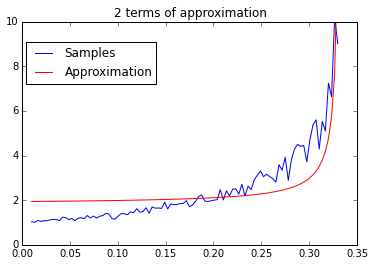

Coefficients = [ 1.82234687  0.03837024]


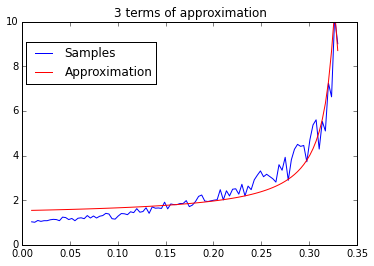

Coefficients = [  1.24262615e+00   9.76927141e-02  -2.42759940e-04]


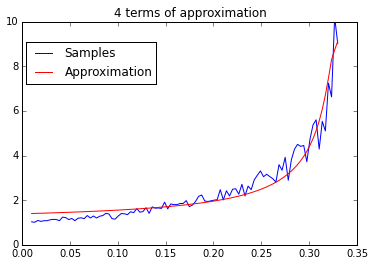

Coefficients = [  9.96010596e-01   1.33457967e-01  -7.37086954e-04   1.27484473e-06]


In [129]:
import scipy.optimize

def model_function(points, coeffs):
    """Approximates expectation of extinction time as partial sum of Taylor series.
    
    Args:
        points: points to compute function
        coeffs: coefficients in Taylor series
    """
    return (sum(c * 1.0 / (1.0 / 3.0 - p) ** k
                for k, c in enumerate(coeffs))
            for p in points)
           
def deviation_function(coeffs, points, samples):
    """Calculates deviation of model function from experimental values.
    
    Args:
        coeffs: coefficients for model function
        points: array of p-coordinates of samples
        samples: array of experimental extinction time values
    Returns:
        list of deviations
    """
    return list(
        sample - value
        for sample, value in zip(samples,
                                 model_function(points, coeffs)))

def best_fit(start_params, points, samples):
    """Finds best (in sense of least squares) parameters for approximation.
    
    Args:
        start_params: starting point for optimization
    """
    result = scipy.optimize.leastsq(
        deviation_function, start_params, args=(points, samples))
    return result[0]


points = numpy.linspace(0.01, 0.33, 100)
samples = [numerical_extinction_time(p) for p in points]    

for n in range(2, 5):
    coeffs = best_fit([0.0] * n, points, samples)
    approximation = list(model_function(points, coeffs))
    _, l_axis = pyplot.subplots()
    l_axis.set_ylim([0, 10])
    l_axis.plot(points, samples, color='b', label='Samples')
    l_axis.plot(points, approximation, color='r', label='Approximation')
    l_axis.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
    pyplot.title('%d terms of approximation' % n)
    pyplot.show()
    print('Coefficients = %s' % coeffs)

Судя по результатам, самый значимый член в сумме - это $\frac{c_1}{\frac{1}{3} - p}$.

### Выбор параметра $N$

Для некоторых значений $p$ проведем численный эксперимент, чтобы определить совпадает ли вероятность выживания и вероятность разрастания, а также найти подходящие значения $N$ для каждого $p$.

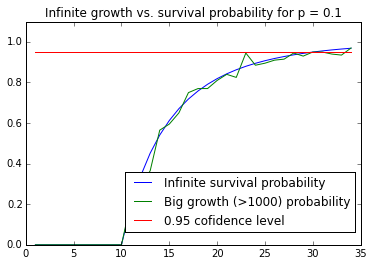

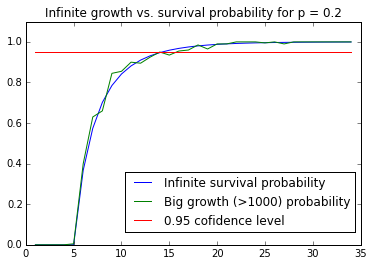

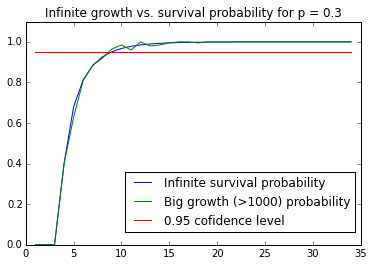

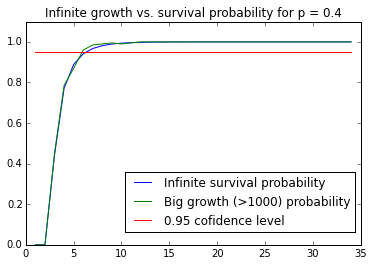

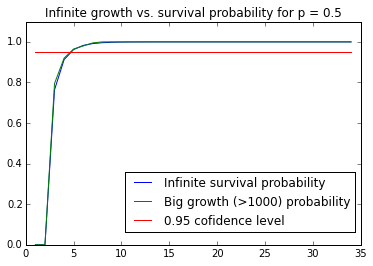

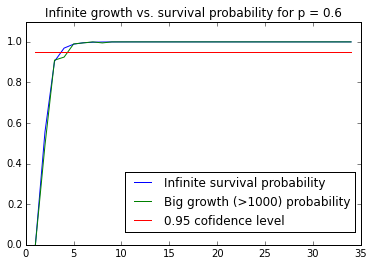

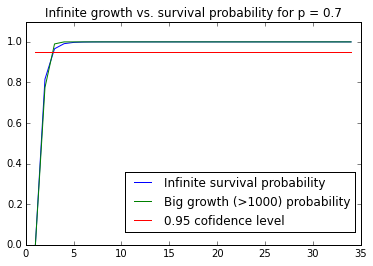

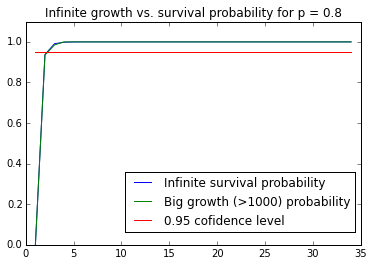

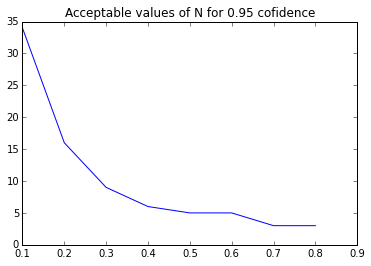

In [130]:
def grow_probability(dist, *, max_iterations=2000, test_runs=200):
    hits = 0

    for _ in range(test_runs):
        for x in sample_process(dist=dist, iterations=max_iterations):
            if x == 0:
                break
            if x >= 1000:
                hits += 1
                break
    return hits / test_runs

def plot_infinite_growth_stats(p_values, n_values, dist, *, confidence=0.95):
    confidence_values = list()
    for p in p_values:
        confidence_values.append(-1)
        not_extinct, num_curve = list(), list()
        for N in n_values:
            cur_dist = functools.partial(dist, N, p)
            not_extinct.append(1 - theoretical_probability(N, p))
            num_curve.append(grow_probability(cur_dist))
            if confidence_values[-1] == -1 and num_curve[-1] > confidence:
                confidence_values[-1] = N

        pyplot.plot(n_values, not_extinct, label='Infinite survival probability')
        pyplot.plot(n_values, num_curve, label='Big growth (>1000) probability')
        pyplot.plot(n_values, [confidence] * len(n_values), 
                    label='%.2f cofidence level' % confidence, color='r')
        axes = pyplot.gca()
        axes.set_ylim([0, 1.1])  # slightly more than 1.0
        pyplot.legend(bbox_to_anchor=(0.90, 0.40),
                      bbox_transform=pyplot.gcf().transFigure)
        pyplot.title('Infinite growth vs. survival probability for p = %.1f' % p)
        pyplot.show()

    pyplot.plot(p_values, confidence_values)
    pyplot.title('Acceptable values of N for %.2f cofidence' % confidence)
    pyplot.show()
    
plot_infinite_growth_stats(numpy.linspace(0.1, 0.8, 8), list(range(1, 35)), numpy.random.binomial)

Итак, по результатам численного эксперимента, вероятность неограниченного возрастания снова совпала с вероятностью бесконечного выживания.

## 3. $\xi \sim R\{0, \ldots, N\}, \eta \mid \{\xi = k\} \sim Bin(N, p)$

### Вероятность вырождения

Производящая функция равна
$$\varphi(z) = Ez^\xi = \frac{1}{N+1}\sum_{k=0}^{N}\sum_{i=0}^{k}{{k}\choose{i}}z^i\cdot p^i (1-p)^{k-i} = \frac{1}{N+1}\sum_{k=0}^{N}(zp + 1 - p)^k = \frac{(zp + 1 - p)^{N+1} - 1}{p(N+1)(z - 1)}. $$

Для нахождения вероятности вырождения необходимо найти наименьший корень уравнения $\varphi(s) = s$. Найти его можно численно.

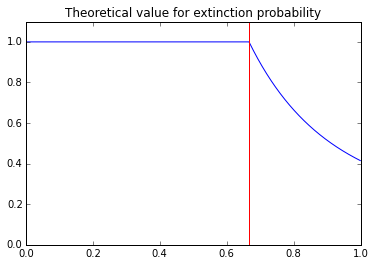

threshold probability ~ 0.667


In [131]:
def theoretical_probability(N, p):
    """Calculates exact theoretical value for extinction probability.
    
    Args:
        N, p: parameters for binomial distribution Bin(N, p)
    
    Returns:
        extinction probability: float from 0 to 1
    """
    poly = [0] * (N + 1)
    for k in range(N + 1):
        for i in range(k + 1):
            coeff = scipy.special.binom(k, i) * (p ** i) * ((1 - p) ** (k - i)) / (N + 1) 
            poly[-i - 1] += coeff
    poly[-2] -= 1.0
    value = 1
    for root in numpy.roots(poly):
        if abs(root.imag) < 1e-5 and 0 < root.real < 1:  # sort out imaginary roots
            value = min(value, root.real)
    return value


N = 3
probs = numpy.linspace(0.001, 0.999, 1000)
values = [theoretical_probability(N, p) for p in probs]

threshold = 0
for i in range(len(values)):
    if values[i] < 0.999:  # 1 - eps since there is numerical error in calculations
        threshold = probs[i]
        break
        
pyplot.plot(probs, values)
axes = pyplot.gca()
axes.set_ylim([0, 1.1])  # slightly more than 1.0

pyplot.axvline(x=threshold, color='r')
pyplot.title('Theoretical value for extinction probability')
pyplot.show()
print('threshold probability ~ %.3f' % threshold)

Поскольку $E\eta = \frac{3p + 2p + p}{4} = \frac{3p}{2}$, пороговая вероятность ожидаемо равна $\frac{2}{3}$. 

### Моделирование

Промоделируем процесс, чтобы убедиться в верности вычислений. Также построим графики тракеторий для разных $p$.

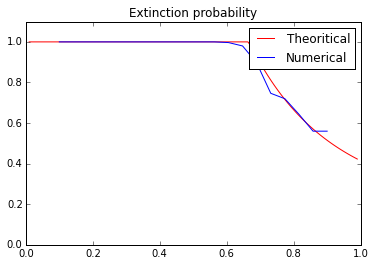

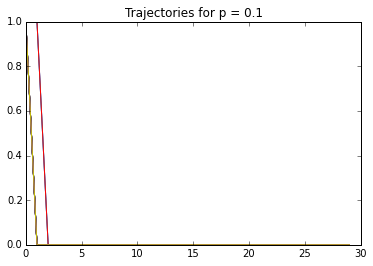

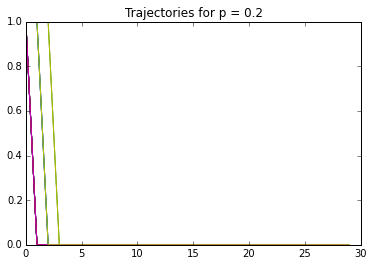

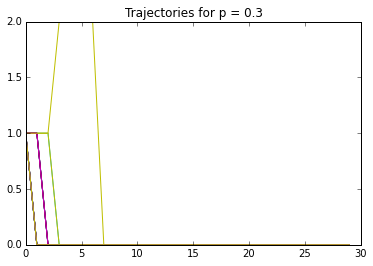

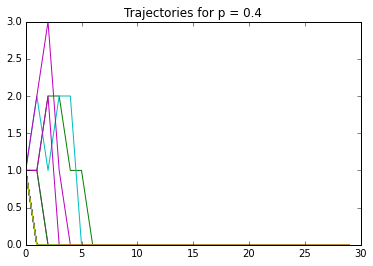

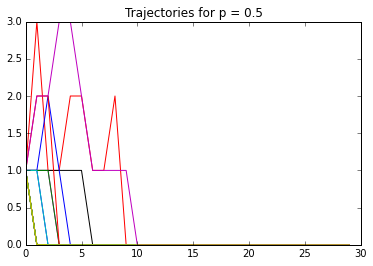

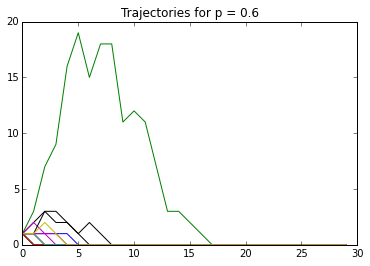

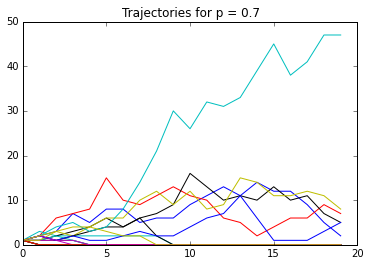

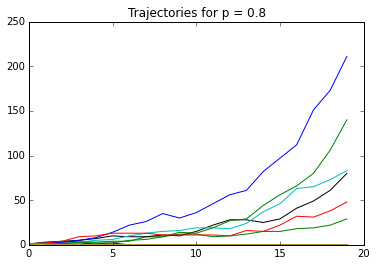

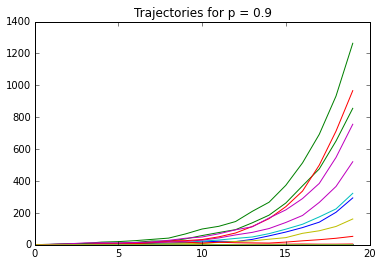

In [132]:
def uniform_binom(N, p, *, size):
    """Generates random integer X from [0; N] uniformly and does X p-coin tosses.
    
    Args:
        N: range for X
        p: P(coin toss = 1) = p
    """
    nums = numpy.random.randint(low=0, high=N+1, size=size)
    result = list()
    for k in nums:
        result.append(numpy.random.binomial(k, p))
    return result

num_curve, num_probs = list(), numpy.linspace(0.1, 0.9, 20)
for p in num_probs:
    binomial_dist = functools.partial(uniform_binom, N, p)
        
    # use only 10 iterations for large p to speed up calculations
    iterations = 50 if p < 0.7 else 15
    num_curve.append(extinction_probability(dist=binomial_dist,
                                            iterations_threshold=iterations))
    
theor_curve, theor_probs = list(), numpy.linspace(0.01, 0.99, 100)
for p in theor_probs:
    theor_curve.append(theoretical_probability(N, p))
    
axes = pyplot.gca()
axes.set_ylim([0, 1.1])  # slightly more than 1.0
pyplot.plot(theor_probs, theor_curve, color='r', label='Theoritical')
pyplot.plot(num_probs, num_curve, color='b', label='Numerical')
pyplot.title('Extinction probability')
pyplot.legend()
pyplot.show()

for p in numpy.linspace(0.1, 0.9, 9):
    binomial_dist = functools.partial(uniform_binom, N, p)
    iterations = 30 if p < 0.66 else 20
    plot_trajectories(dist=binomial_dist, trajectories=20,
                      process_iterations=iterations)
    pyplot.title('Trajectories for p = %.1f' % p)
    pyplot.show()

### Оценка момента вырождения

Для момента вырождения имеем формулу
$$E \tau = \sum_{k=1}^{\infty}P(\tau=k)\cdot k = \sum_{k=1}^{\infty} (\varphi_k(0) - \varphi_{k-1}(0)) \cdot k.$$

Рекуррента еще хуже прежней, поэтому удовлетворимся оценкой матожидания для разных $p < \frac{2}{3}$. Экспериментально же мы можем получить сильно состоятельную оценку из УЗБЧ: $\overline{X} \overset{п.н.}{\rightarrow} EX_i$.

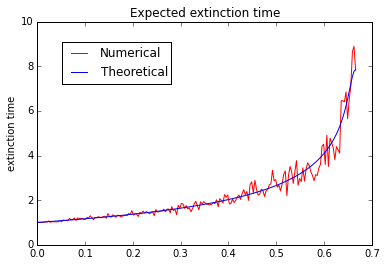

In [133]:
def extinction_time(p, *, iterations):
    """Calculates expected extinction time for process.
    
    Args:
        p: parameter of distribution
        iterations: how terms in infinite sum to consider
    Returns:
        Estimate of expected extinction time.
    """
    zero_prob, expectation = 0.0, 0.0
    
    for step in range(iterations):
        new_prob = ((zero_prob * p + 1 - p) ** 4 - 1) / (4 * p * (zero_prob - 1))
        expectation += (new_prob - zero_prob) * (step + 1)
        zero_prob = new_prob
    return expectation

def sample_extinction_time(dist, *, max_iterations=100):
    """Simulates process with given distribution and calculates extinction time.
    
    Args:
        dist: distribution of branching random variable
        max_iterations: maximum number of iterations to wait for extinction
    """
    extinction_time = 0
    for value in sample_process(dist=dist, iterations=max_iterations):
        if value == 0:
            return extinction_time
        extinction_time += 1
    return max_iterations

def numerical_extinction_time(p, *, test_runs=100):
    """Runs process several times to estimate exepected extinction time.
    
    Args:
        p: parameter of distribution
        test_runs: number of trajectories to sample
    """
    binomial_dist = functools.partial(uniform_binom, N, p)
    values = [sample_extinction_time(binomial_dist) for _ in range(test_runs)]
    return sum(values) / len(values)

expectations = list()
probs = numpy.linspace(0.001, 0.666, 200)
expectations = [extinction_time(p, iterations=200) for p in probs]
num_expectations = [numerical_extinction_time(p) for p in probs]

_, l_axis = pyplot.subplots()
l_axis.plot(probs, num_expectations, color='r', label='Numerical')
l_axis.plot(probs, expectations, color='b', label='Theoretical')
l_axis.set_ylabel('extinction time')
l_axis.set_ylim([0, 10])
pyplot.title('Expected extinction time')
pyplot.legend()
pyplot.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
pyplot.show()

Доверительный интервал считаем по полученной ранее формуле:
$$ P\left( \overline{X} -\frac{\gamma \sqrt{S^2}}{\sqrt{n}} < EX_i \leqslant \overline{X} + \frac{\gamma \sqrt{S^2}}{\sqrt{n}}\right) \rightarrow \alpha, $$
где $S^2$ - выборочная дисперсия, $\gamma$ - квантиль стандартного нормального распределения уровня $\frac{1+\alpha}{2}$.

hit percentage = 0.91


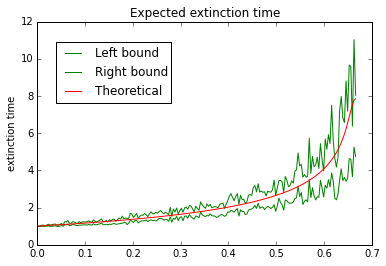

In [134]:
import scipy.stats

def confidence_interval(p, *, alpha=0.95, test_runs=100):
    """Gets samples of process extinction time to construct confidence interval.
    
    Args:
        p: parameter of distribution
        alpha: confidence level
        test_runs: number of samples
    """
    binomial_dist = functools.partial(uniform_binom, N, p)
    values = [sample_extinction_time(binomial_dist) for _ in range(test_runs)]
    mean, deviation = numpy.mean(values), numpy.std(values)
    gamma = scipy.stats.norm.ppf((1 + alpha) / 2)
    return (mean - deviation * gamma / numpy.sqrt(test_runs),
            mean + deviation * gamma / numpy.sqrt(test_runs))
    
steps = 200
expectations = list()
probs = numpy.linspace(0.001, 0.666, steps)
expectations = [extinction_time(p, iterations=200) for p in probs]
intervals = [confidence_interval(p) for p in probs]
l_bounds = [interval[0] for interval in intervals]
r_bounds = [interval[1] for interval in intervals]

hits = sum(1 if l < real <= r else 0
           for real, l, r in zip(expectations, l_bounds, r_bounds))
print('hit percentage = %.2f' % (hits / steps))

_, l_axis = pyplot.subplots()
l_axis.plot(probs, l_bounds, color='g', label='Left bound')
l_axis.plot(probs, r_bounds, color='g', label='Right bound')
l_axis.plot(probs, expectations, color='r', label='Theoretical')
l_axis.set_ylabel('extinction time')
pyplot.title('Expected extinction time')
pyplot.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
pyplot.show()

Замечание: несмотря на то, что по графику кажется, что график имеет тупой пик с конечным максимумом при $p = \frac{2}{3}$, на самом деле это не так. Можно убедиться, что добавляя число учтенных членов в сумме ряда для ожидания, можно получать все большие значения.

### Зависимость $E\tau$ от $p$

Снова будем раскладывать неизвестную зависимость по степеням $\frac{1}{\frac{2}{3} - x}$, так как реальный вид зависимости совершенно не ясен.

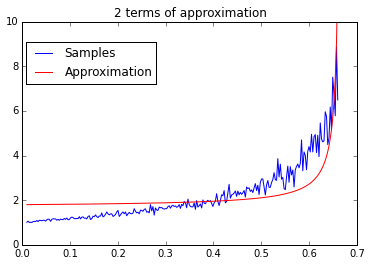

Coefficients = [ 1.69569126  0.06835888]


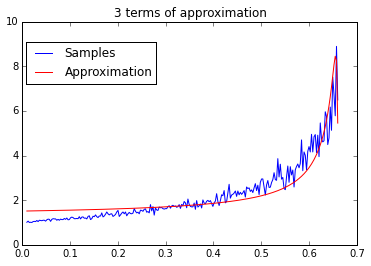

Coefficients = [  1.27457190e+00   1.58568683e-01  -8.71369514e-04]


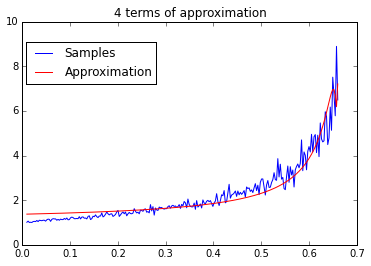

Coefficients = [  1.03264052e+00   2.28379989e-01  -2.76544072e-03   1.01153065e-05]


In [135]:
def model_function(points, coeffs):
    """Approximates expectation of extinction time as partial sum of Taylor series.
    
    Args:
        points: points to compute function
        coeffs: coefficients in Taylor series
    """
    return (sum(c * 1.0 / (2.0 / 3.0 - p) ** k
                for k, c in enumerate(coeffs))
            for p in points)
           
def deviation_function(coeffs, points, samples):
    """Calculates deviation of model function from experimental values.
    
    Args:
        coeffs: coefficients for model function
        points: array of p-coordinates of samples
        samples: array of experimental extinction time values
    Returns:
        list of deviations
    """
    return list(
        sample - value
        for sample, value in zip(samples,
                                 model_function(points, coeffs)))

def best_fit(start_params, points, samples):
    """Finds best (in sense of least squares) parameters for approximation.
    
    Args:
        start_params: starting point for optimization
    """
    result = scipy.optimize.leastsq(
        deviation_function, start_params, args=(points, samples))
    return result[0]


points = numpy.linspace(0.01, 0.66, 250)
samples = [numerical_extinction_time(p) for p in points]    

for n in range(2, 5):
    coeffs = best_fit([0.0] * n, points, samples)
    approximation = list(model_function(points, coeffs))
    _, l_axis = pyplot.subplots()
    l_axis.set_ylim([0, 10])
    l_axis.plot(points, samples, color='b', label='Samples')
    l_axis.plot(points, approximation, color='r', label='Approximation')
    l_axis.legend(bbox_to_anchor=(0.45, 0.85),
              bbox_transform=pyplot.gcf().transFigure)
    pyplot.title('%d terms of approximation' % n)
    pyplot.show()
    print('Coefficients = %s' % coeffs)

Снова доминирующим по порядку слагаемым получается $\frac{c_1}{\frac{2}{3} - x}$.

### Выбор параметра $N$

И опять для некоторых значений $p$ проведем численный эксперимент, чтобы определить совпадает ли вероятность выживания и вероятность разрастания, а также найти подходящие значения $N$ для каждого $p$.

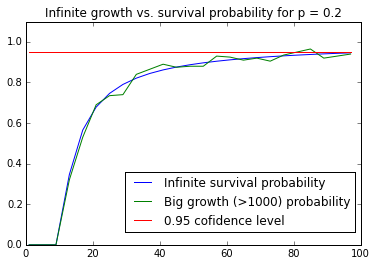

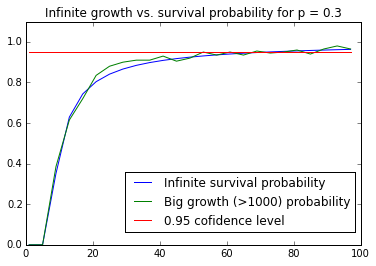

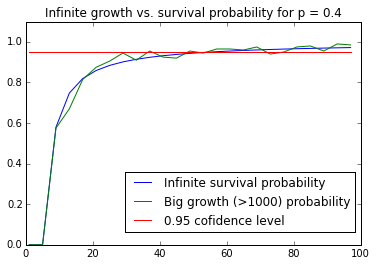

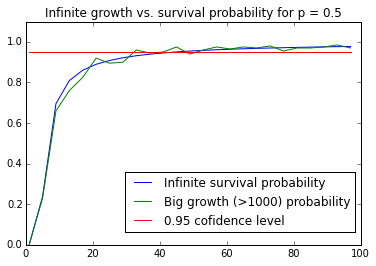

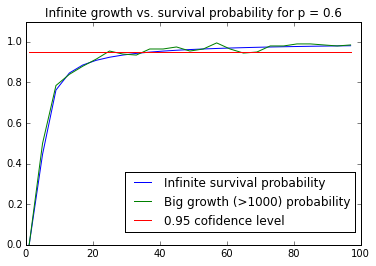

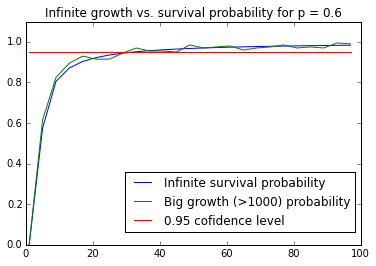

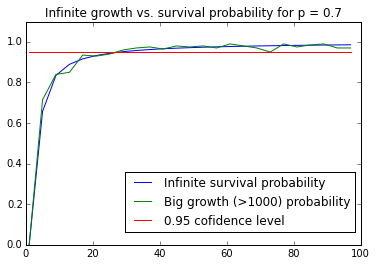

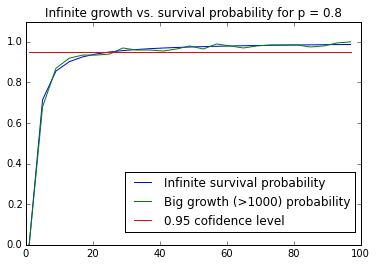

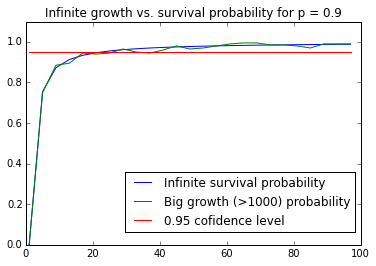

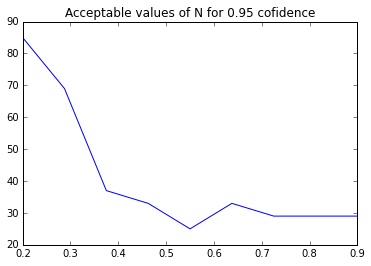

In [136]:
plot_infinite_growth_stats(numpy.linspace(0.2, 0.9, 9), list(range(1, 100, 4)), uniform_binom)

И снова по результату эксперимента вероятность выживания близка к вероятности неограниченного роста.